In [1]:

#Name model
modelname = 'test'


import os
from pathlib import Path
import sys
import numpy as np
import flopy
import SGD
import config
import datetime
import utils

# repo = Path('/scratch/users/ianpg/henry')
repo = Path('/Users/ianpg/Documents/ProjectsLocal/SWIsmall')
workdir = repo.joinpath('work')
figdir = workdir.joinpath('figs')
datadir = repo.joinpath('data')
objdir = repo.joinpath('data', 'objs')
model_ws = repo.joinpath('work', modelname)    
basecase_ws = workdir.joinpath('base_case_3m')



In [2]:
varlist = utils.load_obj('./','varlist_final_fromSherlock')

In [4]:
Lx = 3000.
Ly = 600.
Lz = 80.

henry_top = 3
ocean_elev = 0
delv_first = 5


botm_first = henry_top - delv_first

nlay = int(Lz * 1 / 3)
nrow = int(Ly * (1 / 30))
ncol = int(Lx * (1 / 30))

delv = (Lz - delv_first) / (nlay - 1)
delr = Lx / ncol
delc = Ly / nrow

henry_botm = np.hstack(([botm_first], np.linspace(
    botm_first - delv, henry_top - Lz, nlay - 1)))
delv_vec = np.hstack((delv_first, np.repeat(delv, nlay - 1)))
delv_weight = [x / np.sum(delv_vec) for x in delv_vec]


In [21]:
it = 0
import simulationFFT
def normal_transform(data1,mu1,mu2,sig1,sig2):
    a = sig2/sig1
    b = mu2 - mu1 * a
    return a*data1 + b

def remake_CF(it,varlist,returnhk=False):
    CF_glob = varlist['CF_glob'][it]
    CF_var = varlist['CF_var'][it]
    seed = varlist['seed'][it]
    hk_mean = varlist['hk_mean'][it]
    hk_var = varlist['hk_var'][it]
    por_mean = varlist['por_mean'][it]
    por_var = varlist['por_var'][it]
    corr_len = varlist['corr_len'][it]
    corr_len_yx = varlist['corr_len_yx'][it]
    corr_len_zx = varlist['corr_len_zx'][it]
    clay_lyr_yn = varlist['clay_lyr_yn'][it]
    vario_type = varlist['vario_type'][it]

    #Create Gaussian Simulation
    lcol = int(corr_len/delr)
    llay = int(corr_len*corr_len_zx/np.mean(delv))
    lrow = int(corr_len*corr_len_yx/delc)
    CF_grid = simulationFFT.simulFFT(nrow,nlay, ncol,CF_glob,CF_var,vario_type, lrow , llay, lcol,seed=seed)
    if returnhk:
        return  10**normal_transform(CF_grid,CF_glob,hk_mean,np.sqrt(CF_var),np.sqrt(hk_var))
    else:
        return CF_grid


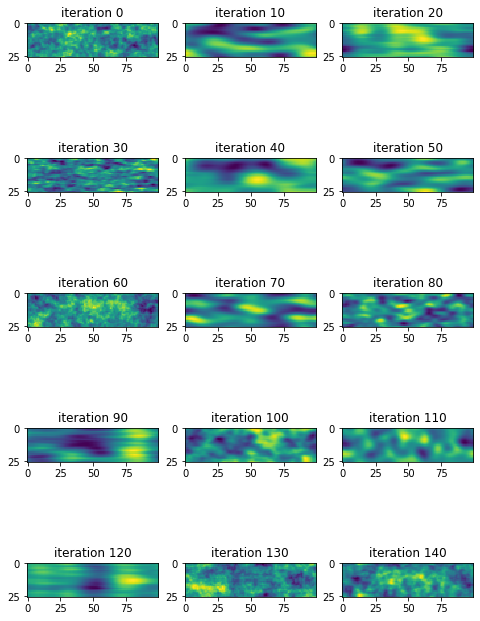

In [16]:
import matplotlib.pyplot as plt

f,axs =plt.subplots(5,3,figsize=(8,12))

for i,ax in enumerate(axs.flatten()):
    it = int(i*10)
    plt.sca(ax)
    plt.imshow(remake_CF(it,varlist)[:,10,:])
    plt.title('iteration {}'.format(it))

In [22]:
CF_mat = {}
for it in range(len(varlist['hk_var'])):
    CF_mat['CF{}'.format(it)] = remake_CF(it,varlist,returnhk=True)

In [23]:
from scipy.io import savemat
savemat('hk_mat_remake.mat',CF_mat,do_compression=True)